In [1]:
import pywt
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import keras
import matplotlib.pyplot as plt
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
from sklearn.preprocessing import StandardScaler



Using TensorFlow backend.


In [2]:
activities_description = {
    1: 'no_sabotage',
    2: 'sabotage'
}

def read_signals(filename):
    with open(filename, 'r') as fp:
        data = fp.read().splitlines()
        data = map(lambda x: x.rstrip().lstrip().split(','), data)
        data = [list(map(float, line)) for line in data]
    return data

def read_labels(filename):        
    with open(filename, 'r') as fp:
        activities = fp.read().splitlines()
        activities = list(map(lambda x: int(x)-1, activities))
    return activities

def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation, :, :]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels

INPUT_FOLDER_TRAIN = '/Users/mahima/Desktop/Sab_data/data_1_2_3_4_RAW/train/data/'
INPUT_FOLDER_TEST = '/Users/mahima/Desktop/Sab_data/data_1_2_3_4_RAW/test/data/'


INPUT_FILES_TRAIN = ["RAW_TP9_train.txt", "RAW_AF7_train.txt", "RAW_AF8_train.txt", "RAW_TP10_train.txt"]

INPUT_FILES_TEST =["RAW_TP9_test.txt", "RAW_AF7_test.txt", "RAW_AF8_test.txt", "RAW_TP10_test.txt"]

LABELFILE_TRAIN = '/Users/mahima/Desktop/Sab_data/data_1_2_3_4_RAW/train/RAW_AF8_y_train.txt'
LABELFILE_TEST = '/Users/mahima/Desktop/Sab_data/data_1_2_3_4_RAW/test/RAW_AF8_y_test.txt'

train_signals, test_signals = [], []

for input_file in INPUT_FILES_TRAIN:
    signal = read_signals(INPUT_FOLDER_TRAIN + input_file)
    train_signals.append(signal)
train_signals = np.transpose(np.array(train_signals), (1, 2, 0))

scalers = {}
for i in range(train_signals.shape[1]):
    scalers[i] = StandardScaler()
    train_signals[:, i, :] = scalers[i].fit_transform(train_signals[:, i, :])
    
for input_file in INPUT_FILES_TEST:
    signal = read_signals(INPUT_FOLDER_TEST + input_file)
    test_signals.append(signal)
test_signals = np.transpose(np.array(test_signals), (1, 2, 0))
for i in range(test_signals.shape[1]):
    test_signals[:, i, :] = scalers[i].transform(test_signals[:, i, :])
    
train_labels = read_labels(LABELFILE_TRAIN)
test_labels = read_labels(LABELFILE_TEST)

[no_signals_train, no_steps_train, no_components_train] = np.shape(train_signals)
[no_signals_test, no_steps_test, no_components_test] = np.shape(test_signals)
no_labels = len(np.unique(train_labels[:]))

print("The train dataset contains {} signals, each one of length {} and {} components ".format(no_signals_train, no_steps_train, no_components_train))
print("The test dataset contains {} signals, each one of length {} and {} components ".format(no_signals_test, no_steps_test, no_components_test))
print("The train dataset contains {} labels, with the following distribution:\n {}".format(np.shape(train_labels)[0], Counter(train_labels[:])))
print("The test dataset contains {} labels, with the following distribution:\n {}".format(np.shape(test_labels)[0], Counter(test_labels[:])))

sab_data_train, sab_data_labels_train = randomize(train_signals, np.array(train_labels))
sab_data_test, sab_data_labels_test = randomize(test_signals, np.array(test_labels))

The train dataset contains 2377 signals, each one of length 64 and 4 components 
The test dataset contains 822 signals, each one of length 64 and 4 components 
The train dataset contains 2377 labels, with the following distribution:
 Counter({1: 1400, 0: 977})
The test dataset contains 822 labels, with the following distribution:
 Counter({1: 451, 0: 371})


In [3]:
import numpy as np
scales = range(1,64)
waveletname = 'morl'
train_size = no_signals_train
train_data_cwt = np.ndarray(shape=(train_size, 63, 63, 4))

for ii in range(0,train_size):
    for jj in range(0,4):
        signal = sab_data_train[ii, :, jj]
        coeff, freq = pywt.cwt(signal, scales, waveletname, 1)
        coeff_ = coeff[:,:63]
        train_data_cwt[ii, :, :, jj] = ((coeff_))

test_size = no_signals_test
test_data_cwt = np.ndarray(shape=(test_size, 63, 63, 4))
for ii in range(0,test_size):
    for jj in range(0,4):
        signal = sab_data_test[ii, :, jj]
        coeff, freq = pywt.cwt(signal, scales, waveletname, 1)
        coeff_ = coeff[:,:63]
        test_data_cwt[ii, :, :, jj] = ((coeff_))

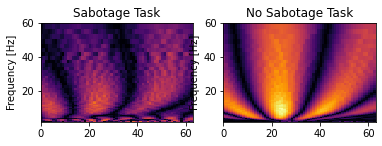

In [4]:
import numpy as np
import matplotlib.pyplot as plt

sab=np.where(sab_data_labels_test==1)
no_sab=np.where(sab_data_labels_test==0)
frex=range(64)
coeff_1=test_data_cwt[sab[0][0], :, :, 2]
coeff_2=test_data_cwt[no_sab[0][0], :, :, 2]



fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)

x, y = np.meshgrid(
    frex,
    np.logspace(np.log10(2), np.log10(60), coeff_.shape[0]))

ax1.title.set_text("Sabotage Task")
ax1.pcolormesh(x, y, np.abs(coeff_1), cmap='inferno')
ax1.set_ylabel("Frequency [Hz]")
ax1.set_ylim(2, 60)
ax2.title.set_text("No Sabotage Task")
ax2.pcolormesh(x, y, np.abs(coeff_2), cmap='inferno')
ax2.set_ylabel("Frequency [Hz]")
ax2.set_ylim(2, 60)
plt.show()


In [5]:
x_train = train_data_cwt
y_train = list(sab_data_labels_train[:train_size])
x_test = test_data_cwt
y_test = list(sab_data_labels_test[:test_size])
img_x = 63
img_y = 63
img_z = 4
num_classes = 2

batch_size = 16
epochs = 10


input_shape = (img_x, img_y, img_z)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices - this is for use in the
# categorical_crossentropy loss below
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (2377, 63, 63, 4)
2377 train samples
822 test samples


In [6]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=input_shape)) 
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer=keras.optimizers.Adam(), 
              metrics=['accuracy'])

model.fit(x_train, y_train, batch_size=batch_size, 
          epochs=epochs, verbose=2, 
          validation_data=(x_test, y_test), 
          )

train_score = model.evaluate(x_train, y_train, verbose=2)
print('Train loss: {}, Train accuracy: {}'.format(train_score[0], train_score[1]))
test_score = model.evaluate(x_test, y_test, verbose=2)
print('Test loss: {}, Test accuracy: {}'.format(test_score[0], test_score[1]))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Train on 2377 samples, validate on 822 samples
Epoch 1/10
 - 20s - loss: 0.7345 - accuracy: 0.5810 - val_loss: 0.6862 - val_accuracy: 0.5499
Epoch 2/10
 - 21s - loss: 0.6166 - accuracy: 0.6815 - val_loss: 0.7463 - val_accuracy: 0.6363
Epoch 3/10
 - 21s - loss: 0.1987 - accuracy: 0.9297 - val_loss: 0.1165 - val_accuracy: 0.9623
Epoch 4/10
 - 21s - loss: 0.0373 - accuracy: 0.9920 - val_loss: 0.0945 - val_accuracy: 0.9696
Epoch 5/10
 - 21s - loss: 0.0102 - accuracy: 0.9975 - val_loss: 0.0405 - val_accuracy: 0.9866
Epoch 6/10
 - 20s - loss: 0.0033 - accuracy: 0.9996 - val_loss: 0.0424 - val_accuracy: 0.9878
Epoch 7/10
 - 20s - loss: 0.0311 - accuracy: 0.9941 - val_loss: 0.1441 - val_accuracy: 0.9793
Epoch 8/10
 - 19s - loss: 0.0690 - accuracy: 0.9836 - val_loss: 0.0800 - val_accuracy: 0.9745
Epoch 9/10
 - 19s - loss: 0.0308 - accuracy: 0.9958 - val_loss: 0.0549 - val_accuracy: 0.9805
Epoch 10/10
 - 20s - los